In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import ANN_classes

In [2]:
csvdata = []
with open('data_m.csv', 'rb') as gtu_file:
    reader = csv.reader(gtu_file)
    for row in reader: 
        csvdata.append(row)
data_m = np.array(csvdata, str)

In [3]:
data_Nfp = np.add(
            np.multiply(
                data_m[:, 13].astype(float),
                data_m[:, 14].astype(float)),
            data_m[:, 28].astype(float))

In [4]:
Qvpg = 8251*4.1868  # кДж/м3
rhopg = 0.7078  # кг/м3
Qmpg = Qvpg / rhopg # кДж/кг

In [5]:
Qmptr = []
Qvptr = []
Etam = np.array([])

for i in np.arange(len(data_m)):
    # массовый расход
    Qmptr.append(Qmpg*float(data_m[i, 36])/3600)  # кДж*с
    try:
        Etam = np.append(Etam, float(data_Nfp[i])/(Qmptr[i]*1000))  # %
    except ZeroDivisionError:
        Etam = np.append(Etam, 0)

In [6]:
N_ladder = [np.arange(*i) for i in [(118, 174), (184,304), (310,372), (374,476), (486,574), (586,648),
                                    (676,760), (770,844), (852,1058), (1130,1402), (1412,1486), (1498,1594),
                                    (1700,1734),  # Вот здесь будем приклеивать ещё один кусочек
                                    (1820,1892), (1896,1950), (2042,2132)]]
N_ladder[12] = np.append(N_ladder[12], np.arange(1798,1818))  # Доклеиваем кусочек

# Выборки по мощности и остальным параметрам (необработанные)
data_Nfp_seq = [data_Nfp[i] for i in N_ladder]
data_Etam = [Etam[i] for i in N_ladder]
# data_TET = [data_m[i, 3].astype(float) for i in N_ladder]
# data_Tug = [data_criomean[i] for i in N_ladder]
# data_nob = [data_m[i, 1].astype(float) for i in N_ladder]
# data_G1t = [data_m[i, 36].astype(float) for i in N_ladder]
# data_Ptp = [data_m[i, 11].astype(float) for i in N_ladder]
# data_Nsn_ld = [data_Nsn[i] for i in N_ladder]

In [7]:
import custom_classes
reload(custom_classes)
sWorker = custom_classes.StatWorker()

In [8]:
data_Etam_mask = [sWorker.clean3sigma(i) for i in data_Etam]
data_Etam_Nfp_mask = [sWorker.clean3sigma(i[0][i[1]]) for i in zip(data_Nfp_seq, data_Etam_mask)]
sWorker.set_alpha(0.05)
data_Nfp_Etam_seq_masked_means = [i[0][i[1]][i[2]].mean() 
                             for i in zip(data_Nfp_seq, data_Etam_mask, data_Etam_Nfp_mask)]
data_Nfp_Etam_seq_masked_means = np.array(data_Nfp_Etam_seq_masked_means)
data_Etam_masked_means = [i[0][i[1]][i[2]].mean() 
                          for i in zip(data_Etam, data_Etam_mask, data_Etam_Nfp_mask)]
data_Etam_masked_means = np.array(data_Etam_masked_means)
data_Etam_conf = [sWorker.conf_level(i[0][i[1]][i[2]])['rng'] for i in zip(data_Etam, data_Etam_mask, data_Etam_Nfp_mask)]
data_Nfp_Etam_conf = [sWorker.conf_level(i[0][i[1]][i[2]])['rng'] for i in zip(data_Nfp_seq, data_Etam_mask, data_Etam_Nfp_mask)]

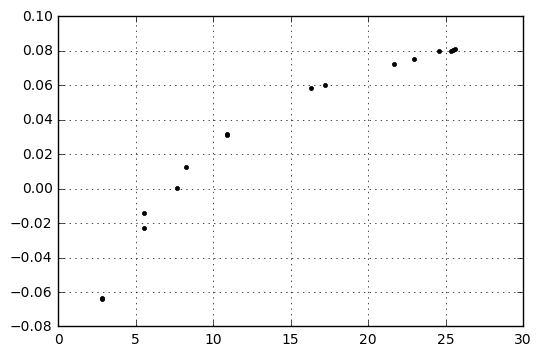

In [9]:
fig = plt.figure()
ax1 = plt.subplot(111)
ax1.plot(data_Nfp_Etam_seq_masked_means/1000, data_Etam_masked_means-0.15, 'k.')
ax1.grid(True)
plt.show()

In [10]:
a = np.array([1, 2, 3])
a.tolist()

[1, 2, 3]

In [11]:
np.array([0, 2, 3]) == np.array([0, 2, 3])

array([ True,  True,  True], dtype=bool)

In [12]:
set_input = data_Nfp_Etam_seq_masked_means/1000
set_output = data_Etam_masked_means*100#-np.median(data_Etam_masked_means)

In [13]:
set_input = np.arange(20)
set_output = np.arange(0, 40, 2)

In [14]:
ANN2 = ANN_classes.NNetwork(1,5,2)

In [15]:
reload(ANN_classes)

<module 'ANN_classes' from 'ANN_classes.pyc'>

In [16]:
ANN1 = ANN_classes.NNetwork(1, 2, 1)
# ANN1.cfg_input(2)
ANN1.cfg_mass()
ANN1.nwgh_reset(1)ss

SyntaxError: invalid syntax (<ipython-input-16-6c49ac6d09cd>, line 4)

In [ ]:
ANN1.Lii[0].Vw.v

In [ ]:
ANN1.L1[0].Vw.v

In [ ]:
ANN1.L1[1].Vw.v

In [ ]:
ANN1.Loo[0].Vw.v

In [ ]:
ANN1.forward([10])

In [ ]:
ANN1.Lii[0].Vw.g

In [ ]:
ANN_classes.unpackval(ANN1.VL1)

In [ ]:
ANN1.getnetgrad([50])

In [ ]:
ANN1.Loo[0].Vii.g

In [ ]:
ANN1.Lii[0].Vii.v

In [ ]:
ANN_classes.unpackgrad(ANN1.VLii)

In [ ]:
[sum(g) for g in ANN_classes.unpackgrad(ANN1.VLii).T]

In [ ]:
ANN1.Lii[0].Vw.g

In [ ]:
ANN1.L1[0].Vw.v*ANN1.VL1[0].g[:-1]*0.01

In [ ]:
ANN1.backward()

In [ ]:
ANN1.ncommit()

In [ ]:
fig = plt.figure()
ax1 = plt.subplot(111)
ax2 = ax1.twinx()
#ax1.plot(set_input, set_output, 'k.')
ax1.plot(dxx, dyy, 'k-')
[ax1.plot(dxx, dyy_p[:,i], 'g') for i in xrange(len(dyy_p[0, :]))]
ax1.grid(True)
plt.show()

In [ ]:
for _ in xrange(1):
    pick = np.random.randint(len(set_input))
#     pick = 0
    ANN1.forward([set_input[pick]])
    print ANN1.Vii
    ANN1.getnetgrad([set_output[pick]])
    ANN1.backward()
    ANN1.forward([set_input[pick]])
    ANN1.VLoo[0].v[0]
    #######
    dxx = np.linspace(0, max(set_input), 50)
    dyy = np.zeros([50])
    dyy_p = np.zeros([50,3])
    c = 0
    for x in dxx:
        ANN1.forward([x])
        dyy[c] = ANN1.VLoo[0].v[0]
        dyy_p[c] = ANN_classes.unpackval(ANN1.VL1)[0]*ANN1.Loo[0].Vw.v
        c += 1
    ANN_iter += 1
print 'Ann_iter: {}'.format(ANN_iter)
fig = plt.figure()
ax1 = plt.subplot(111)
ax2 = ax1.twinx()
ax1.plot(set_input, set_output, 'k.')
ax1.plot(dxx, dyy, 'k-')
[ax1.plot(dxx, dyy_p[:,i], 'g') for i in xrange(len(dyy_p[0, :]))]
ax1.grid(True)
plt.show()

In [ ]:
for _ in xrange(1):
    pick = np.random.randint(len(set_input))
#     pick = 0
    ANN1.forward([set_input[pick]])
    print ANN1.Vii
    ANN1.getnetgrad([set_output[pick]])
    ANN1.backward()
    ANN1.forward([set_input[pick]])
    ANN1.VLoo[0].v[0]
    #######
    dxx = np.linspace(0, max(set_input), 50)
    dyy = np.zeros([50])
    dyy_p = np.zeros([50,3])
    c = 0
    for x in dxx:
        ANN1.forward([x])
        dyy[c] = ANN1.VLoo[0].v[0]
        dyy_p[c] = ANN_classes.unpackval(ANN1.VL1)[0]*ANN1.Loo[0].Vw.v
        c += 1
    ANN_iter += 1
print 'Ann_iter: {}'.format(ANN_iter)
fig = plt.figure()
ax1 = plt.subplot(111)
ax2 = ax1.twinx()
ax1.plot(set_input, set_output, 'k.')
ax1.plot(dxx, dyy, 'k-')
[ax1.plot(dxx, dyy_p[:,i], 'g') for i in xrange(len(dyy_p[0, :]))]
ax1.grid(True)
plt.show()